# Convert recording and sorting extractor data to TINT format

The Hussaini lab uses the proprietary TINT software from Axona to analyze extracellular electrophysiology data. While we are already able to read various data formats from Axona (`raw` data or `unit` data) into spikeinterface, perform preprocessing, spike sorting and export the data to NWB, we also want to allow to export data to the TINT format. 

The TINT format is essentially the same as the `unit` data, including `.X` and `.pos` files, but also `.cut` or `.clu`. The latter two contain information about the spike sorted units.

The conversion can be facilitated by using the existing tools from the Hussaini lab, which [convert `.bin` data to `.X` and `.pos`](https://github.com/HussainiLab/BinConverter/blob/master/BinConverter/core/ConversionFunctions.py). Some of this code is only relevant for using the GUI, which did not work for me. I cleared out GUI code and ran a conversion from `.bin` to `.X` and `.pos` in this notebook: [explore_hussaini_tools.ipynb](https://github.com/sbuergers/hussaini-lab-to-nwb-notebooks/blob/master/explore_hussaini_tools.ipynb).

They also already wrote a [`write_cut()`](https://github.com/GeoffBarrett/gebaSpike/blob/967097ec28592182ef9783d2d391930e1c63ca58/gebaSpike/core/writeCut.py) function.

We can test our solutions by reading data with these [Hussaini lab tools](https://github.com/HussainiLab/BinConverter/blob/master/BinConverter/core/Tint_Matlab.py). 

<a id='index'></a>
## Index

* [Testing functions](#testing_functions)
* [Hussaini-lab functions](#hussaini-lab_functions)
* [Convert Sorting Extractor to TINT](#Convert_sorting_extractor_to_tint)

In [1]:
import sys
import os
from pathlib import Path
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16, 5)
plt.rcParams.update({'font.size':14})
%matplotlib inline

import spikeextractors as se
import spiketoolkit as st
import spikewidgets as sw

from spikeextractors.extractors.neoextractors import AxonaRecordingExtractor
from spikeextractors.extractors.axonaunitrecordingextractor import AxonaUnitRecordingExtractor

from hussaini_lab_to_nwb import TintConverter
from hussaini_lab_to_nwb.tint_conversion.export_spike_waveforms import get_waveforms, parse_generic_header

print(sys.version, sys.platform, sys.executable)

3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0] linux /home/sbuergers/spikeinterface/spikeinterface_new_api/venv/bin/python


In [2]:
# Directories

dir_name = Path('/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/sample_bin_to_tint_no_bin')
print('Input directory = ', dir_name)

save_dir = dir_name / 'conversion_to_tint'
save_dir.mkdir(parents=True, exist_ok=True)
print('Output directory = ', save_dir)

Input directory =  /mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/sample_bin_to_tint_no_bin
Output directory =  /mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/sample_bin_to_tint_no_bin/conversion_to_tint


In [3]:
# Read cached spikeextractors data

r_cache = se.load_extractor_from_pickle(os.path.join(dir_name, 'cached_unit_data_no_bin_preproc.pkl'))

In [4]:
# Read NWB recording data

nwb_dir = Path(dir_name, 'nwb')
recording_nwb = se.NwbRecordingExtractor(nwb_dir / 'axona_tutorial_re2.nwb')

/home/sbuergers/spikeinterface/spikeinterface_new_api/venv/lib/python3.8/site-packages/hdmf/common/table.py:442: UserWarning: An attribute 'name' already exists on DynamicTable 'electrodes' so this column cannot be accessed as an attribute, e.g., table.name; it can only be accessed using other methods, e.g., table['name'].
  warn(msg)


In [5]:
# Read NWB sorting data

sorting_nwb = se.NwbSortingExtractor(nwb_dir / 'axona_se_MS4.nwb', sampling_frequency=48000)

In [6]:
# Show data types of different objects

print(type(r_cache))
print(type(recording_nwb))
print(type(sorting_nwb))

<class 'spikeextractors.extractors.bindatrecordingextractor.bindatrecordingextractor.BinDatRecordingExtractor'>
<class 'spikeextractors.extractors.nwbextractors.nwbextractors.NwbRecordingExtractor'>
<class 'spikeextractors.extractors.nwbextractors.nwbextractors.NwbSortingExtractor'>


<a id="testing_functions"></a>
## Testing functions
[back to index](#index)

As we start exporting to putative TINT format, we will want to check if we can read it back in.

In [7]:
def test_axonaunitrecordingextractor(filename):
    '''Reads UNIT data with AxonaUnitRecordingExtractor and
    performs some simple operations as a sanity check. 
    
    Parameters
    ----------
    filename : str or Path
        Full filename of `.set` file (could be any extension actually)
    '''
    re = AxonaUnitRecordingExtractor(filename=filename)
    
    # TEST AXONARECORDINGEXTRACTOR
    # Retrieve some simple recording information and print it
    recording = re
    print('Channel ids = {}'.format(recording.get_channel_ids()))
    print('Num. channels = {}'.format(len(recording.get_channel_ids())))
    print('Sampling frequency = {} Hz'.format(recording.get_sampling_frequency()))
    print('Num. timepoints = {}'.format(recording.get_num_frames()))
    print('Stdev. on third channel = {}'.format(np.std(recording.get_traces(channel_ids=2))))
    print('Location of third electrode = {}'.format(
        recording.get_channel_property(channel_id=2, property_name='location')))
    print('Channel groups = {}'.format(recording.get_channel_groups()))
    
    # TEST NEO_READER (axonaio)
    print(recording.neo_reader.header['signal_channels'])
    
    
def test_tetrode_files(filename):
    '''Reads UNIT data with AxonaUnitRecordingExtractor and
    performs some simple operations as a sanity check. 
    Will only test .X  and .set files (no .clu or .cut, no .pos).
    
    Parameters
    ----------
    filename : str or Path
        Full filename of `.set` file (could be any extension actually)
    '''
    test_axonaunitrecordingextractor(filename)

In [8]:
set_file_to_tint = dir_name / 'conversion_to_tint' / 'axona_sample.set'
print(set_file_to_tint)

set_file = dir_name / 'axona_sample.set'
print(set_file)

/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/sample_bin_to_tint_no_bin/conversion_to_tint/axona_sample.set
/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/sample_bin_to_tint_no_bin/axona_sample.set


In [9]:
recording = AxonaUnitRecordingExtractor(filename=set_file, noise_std=0)

In [12]:
tint_converter = TintConverter(recording, sorting_nwb, set_file_to_tint)
tint_converter.write_to_tint()

Writing axona_sample.1
Writing axona_sample.2
Writing axona_sample.3
Writing axona_sample.4
Write unit labels for tetrode 0 to .cut and .clu
Write unit labels for tetrode 1 to .cut and .clu
Write unit labels for tetrode 2 to .cut and .clu
Write unit labels for tetrode 3 to .cut and .clu


In [13]:
recording_y = AxonaUnitRecordingExtractor(filename=set_file_to_tint, noise_std=0)

The data in the exported recording is scaled differently compared to the original! Why?!

See below:

In [14]:
# prepare waveform dict (write_to_tetrode_files(recording, sorting, group_ids, set_file))

from hussaini_lab_to_nwb.tint_conversion.export_spike_waveforms import (
    write_to_tetrode_files,
    get_waveforms,
    parse_generic_header,
    combine_units_on_tetrode
)

from hussaini_lab_to_nwb.tint_conversion.export_spike_waveforms import get_unit_group_ids

sampling_rate = recording.get_sampling_frequency()
group_ids = get_unit_group_ids(sorting_nwb)
header = parse_generic_header(set_file)

group_id = group_ids[0]

# get spike samples and waveforms of this group / tetrode
group_unit_ids = [i for i, gid in enumerate(group_ids) if gid == group_id]
group_waveforms = get_waveforms(recording, sorting_nwb, group_unit_ids, header)
group_spike_samples = sorting_nwb.get_units_spike_train(unit_ids=group_unit_ids)

# assign each waveform to it's spike sample in a dictionary
waveform_dict = combine_units_on_tetrode(group_spike_samples, group_waveforms)

In [15]:
recording.get_num_frames()

57600

### Try to find a solution like `st.postprocessing.get_unit_waveforms()`, without converting from float to in

In [16]:
print(sorting_nwb.get_shared_unit_property_names())
sorting_nwb.get_unit_property(unit_id=0, property_name='group')

['firing_rate', 'group', 'halfwidth', 'isi_violation', 'max_channel', 'peak_to_valley', 'peak_trough_ratio', 'recovery_slope', 'repolarization_slope', 'snr', 'template', 'waveforms_channel_idxs']


0

In [17]:
sorting_nwb.get_unit_spike_train

<bound method NwbSortingExtractor.get_unit_spike_train of <spikeextractors.extractors.nwbextractors.nwbextractors.NwbSortingExtractor object at 0x7fa36e7edf70>>

In [18]:
unit_spike_train = sorting_nwb.get_units_spike_train(unit_ids=[0, 1])
print(unit_spike_train)

[array([  806,  1638,  1854,  2044,  2642,  2929,  4106,  5032,  5982,
        6056,  6711,  7489,  7691,  8229, 10222, 11061, 11961, 13920,
       14137, 16582, 17070, 17403, 17661, 18316, 18751, 18789, 18964,
       20220, 20854, 22096, 24185, 24770, 24788, 25149, 26285, 26382,
       26529, 27031, 27706, 29057, 29884, 30126, 30362, 30739, 31774,
       33709, 34159, 36395, 36676, 37662, 38283, 38612, 39187, 40663,
       41048, 41490, 41602, 42303, 43438, 44502, 44692, 44973, 45147,
       45616, 45747, 45780, 46531, 47303, 49143, 49495, 52031, 55848]), array([  472,  1579,  1823,  2255,  2345,  3132,  3869,  3946,  4678,
        5789,  5810,  6242,  6264,  6410,  6699,  6725,  6938,  7077,
        7256,  8059,  9778,  9799, 10239, 10722, 11103, 11946, 12703,
       12769, 12893, 13086, 13648, 14073, 14483, 14972, 15007, 15302,
       15343, 15679, 15711, 15963, 16459, 16756, 17751, 18986, 19221,
       19597, 19910, 20142, 22564, 22645, 22720, 23303, 24087, 24588,
       24605, 254

In [19]:
recording_timestamps = recording.neo_reader.get_spike_timestamps() // 2
recording_timestamps[0:10]

array([ 464,  786, 1570, 1632, 1826, 2017, 2228, 2322, 2493, 2634],
      dtype=int32)

In [20]:
spike_timestamp - samples_before

NameError: name 'spike_timestamp' is not defined

In [ ]:
# The culprid seems to be st.postprocessing.get_unit_waveforms()...

sampling_rate = recording.get_sampling_frequency()
samples_before = int(10)
samples_after = int(40)

ms_before = samples_before / (sampling_rate / 1000) + 0.001
ms_after = samples_after / (sampling_rate / 1000) + 0.001

waveforms = st.postprocessing.get_unit_waveforms(
    recording,
    sorting_nwb,
    unit_ids=0,
    max_spikes_per_unit=None,
    grouping_property='group',
    recompute_info=True,
    ms_before=ms_before,
    ms_after=ms_after,
    return_idxs=False,
    return_scaled=False,
    dtype=np.int8
)

In [21]:
waveforms

[memmap([[[ -8,  -4,   1, ...,   0,   0,   0],
          [-13, -11,  -8, ...,   0,   0,   0],
          [-23, -17,  -7, ...,   0,   0,   0],
          [-38, -20,   0, ...,   0,   0,   0]],
 
         [[  0,  59,  78, ...,   0,   0,   0],
          [  0,   7,  16, ...,   0,   0,   0],
          [-14,   0,  15, ...,   0,   0,   0],
          [  6,  19,  31, ...,   0,   0,   0]],
 
         [[ 38,  25,   8, ...,   0,   0,   0],
          [ 32,  36,  31, ...,   0,   0,   0],
          [ 39,  40,  31, ...,   0,   0,   0],
          [ 27,  14,  -4, ...,   0,   0,   0]],
 
         ...,
 
         [[  0,   0,   0, ...,  12,  16,  18],
          [  0,   0,   0, ..., -18,  -7,   6],
          [  0,   0,   0, ...,  -5,   6,  20],
          [  0,   0,   0, ..., -26, -10,   3]],
 
         [[ 54,  76,  80, ...,   0,   0,   0],
          [ 12,  35,  61, ...,   0,   0,   0],
          [ 26,  54,  65, ...,   0,   0,   0],
          [ 40,  60,  62, ...,   0,   0,   0]],
 
         [[  0,   0,   0, ...

In [44]:
recording.neo_reader.get_spike_raw_waveforms()[0, 0, 8:26]

memmap([ 52,  52,  44,  29,  17,  10,   4,  -4, -16, -23, -20,  -7,  -7,
         21,  27,  27,  22,  11], dtype=int8)

In [45]:
recording_y.neo_reader.get_spike_raw_waveforms()[0, 0, 0:18]  # Still correct!!!

memmap([ 52,  52,  44,  29,  17,  10,   4,  -4, -16, -23, -20,  -7,  -7,
         21,  27,  27,  22,  11], dtype=int8)

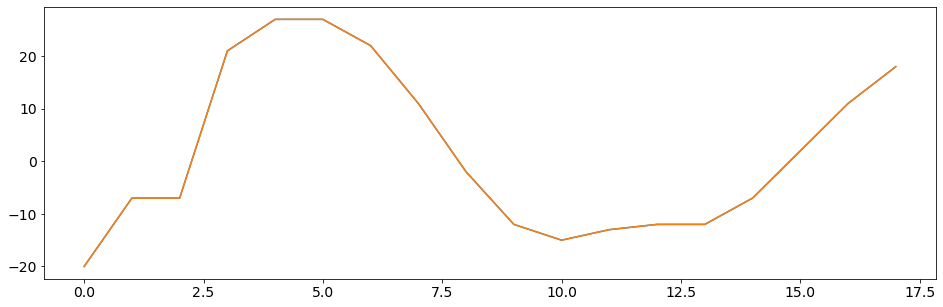

In [46]:
%matplotlib inline

plt.rcParams["figure.figsize"] = (16, 5)
plt.rcParams.update({'font.size':14})

#w_ts = sw.plot_timeseries(recording, trange=[0, 0.3])
dat1 = recording.get_traces(channel_ids=[0], return_scaled=False).ravel()
dat2 = recording_y.get_traces(channel_ids=[0], return_scaled=False).ravel()
plt.plot(dat1[472:472+18])
plt.plot(dat2[472:472+18])

In [179]:
recording.get_traces?

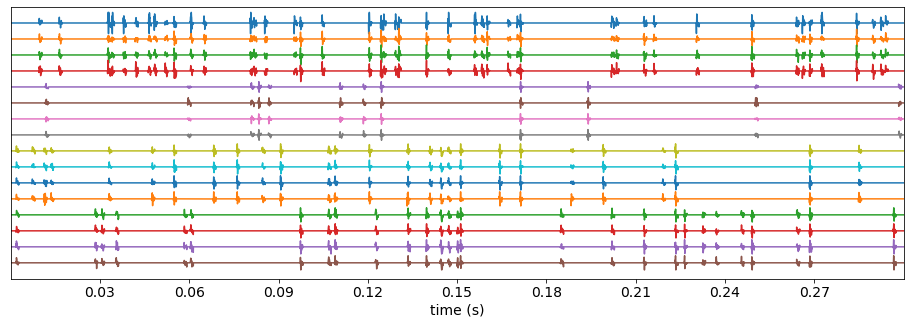

In [49]:
%matplotlib inline

plt.rcParams["figure.figsize"] = (16, 5)
plt.rcParams.update({'font.size':14})

w_ts = sw.plot_timeseries(recording, trange=[0, 0.3])

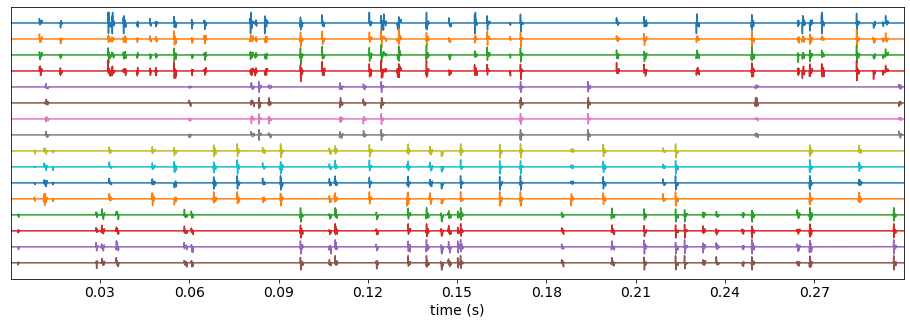

In [47]:
w_ts = sw.plot_timeseries(recording_y, trange=[0, 0.3])

<a id="hussaini-lab_functions"></a>
## Hussaini-lab functions
[back to index](#index)

`gebaSpike` actually wants already existing `.cut` or `.clu` files, and allows modifying them. So these might not be all that useful for exporting to `.cut` or `.clu`.

Test writing data to tetrode files (following Hussaini lab implementation - is this the best way?)

In [8]:
# From 
# https://github.com/HussainiLab/BinConverter/blob/master/BinConverter/core/ConvertTetrode.py

import os
from BinConverter.core.conversion_utils import get_set_header
import numpy as np
import struct


def write_tetrode(filepath, data, Fs):

    session_path, session_filename = os.path.split(filepath)
    tint_basename = os.path.splitext(session_filename)[0]
    set_filename = os.path.join(session_path, '%s.set' % tint_basename)

    n = len(data)

    header = get_set_header(set_filename)

    with open(filepath, 'w') as f:
        num_chans = 'num_chans 4'
        timebase_head = '\ntimebase %d hz' % (96000)
        bp_timestamp = '\nbytes_per_timestamp %d' % (4)
        # samps_per_spike = '\nsamples_per_spike %d' % (int(Fs*1e-3))
        samps_per_spike = '\nsamples_per_spike %d' % (50)
        sample_rate = '\nsample_rate %d hz' % (Fs)
        b_p_sample = '\nbytes_per_sample %d' % (1)
        # b_p_sample = '\nbytes_per_sample %d' % (4)
        spike_form = '\nspike_format t,ch1,t,ch2,t,ch3,t,ch4'
        num_spikes = '\nnum_spikes %d' % (n)
        start = '\ndata_start'

        write_order = [header, num_chans, timebase_head,
                       bp_timestamp,
                       samps_per_spike, sample_rate, b_p_sample, spike_form, num_spikes, start]

        f.writelines(write_order)

    # rearranging the data to have a flat array of t1, waveform1, t2, waveform2, t3, waveform3, etc....
    spike_times = np.asarray(sorted(data.keys()))

    # the spike times are repeated for each channel so lets tile this
    spike_times = np.tile(spike_times, (4, 1))
    spike_times = spike_times.flatten(order='F')

    spike_values = np.asarray([value for (key, value) in sorted(data.items())])

    # this will create a (n_samples, n_channels, n_samples_per_spike) => (n, 4, 50) sized matrix, we will create a
    # matrix of all the samples and channels going from ch1 -> ch4 for each spike time
    # time1 ch1_data
    # time1 ch2_data
    # time1 ch3_data
    # time1 ch4_data
    # time2 ch1_data
    # time2 ch2_data
    # .
    # .
    # .

    spike_values = spike_values.reshape((n * 4, 50))  # create the 4nx50 channel data matrix

    # make the first column the time values
    spike_array = np.hstack((spike_times.reshape(len(spike_times), 1), spike_values))

    data = None
    spike_times = None
    spike_values = None

    spike_n = spike_array.shape[0]

    t_packed = struct.pack('>%di' % spike_n, *spike_array[:, 0].astype(int))
    spike_array = spike_array[:, 1:]  # removing time data from this matrix to save memory

    spike_data_pack = struct.pack('<%db' % (spike_n*50), *spike_array.astype(int).flatten())

    spike_array = None

    # now we need to combine the lists by alternating

    comb_list = [None] * (2*spike_n)
    comb_list[::2] = [t_packed[i:i + 4] for i in range(0, len(t_packed), 4)]  # breaks up t_packed into a list,
    # each timestamp is one 4 byte integer
    comb_list[1::2] = [spike_data_pack[i:i + 50] for i in range(0, len(spike_data_pack), 50)]  # breaks up spike_data_
    # pack and puts it into a list, each spike is 50 one byte integers

    t_packed = None
    spike_data_pack = None

    write_order = []
    with open(filepath, 'rb+') as f:

        write_order.extend(comb_list)
        write_order.append(bytes('\r\ndata_end\r\n', 'utf-8'))

        f.seek(0, 2)
        f.writelines(write_order)

<a id="Convert_sorting_extractor_to_tint"></a>
## Convert Sorting extractor to TINT
[back to index](#index)

There are several points in the pipeline at which we might want to export to TINT. Ideally it should work for any `SortingExtractor` object!

In [9]:
print('Where do we load data from?\n', dir_name)

Where do we load data from?
 /mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/sample_bin_to_tint_no_bin


From a sorting extractor we can obtain a list unit spike sample arrays. We can convert this to the .clu or .cut type array of unit ID labels for each spike.


In [10]:
cut_filename = Path('/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/Axona_Tint_1ms/20201004_Tint_1.cut')

basename = os.path.basename(os.path.splitext(cut_filename)[0])

print(basename)

20201004_Tint_1


In [11]:
filename = Path('/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/Axona_Tint_1ms/20201004_Tint.set')
print(filename)

Path(str(filename.with_suffix('')) + '_{}'.format(1) + '.cut')

/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/Axona_Tint_1ms/20201004_Tint.set


PosixPath('/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/Axona_Tint_1ms/20201004_Tint_1.cut')

### Write unit labels to .cut and .clu files

In [12]:
def convert_spike_train_to_label_array(spike_train):
    '''Takes a list of arrays, where each array is a series of
    sample points at which a spike occured for a given unit
    (each list item is a unit). Converts to .cut array, i.e.
    orders spike samples from all units and labels each sample
    with the appropriate unit ID.
    
    Parameters
    ----------
    spike_train : List of np.arrays
        Output of `get_units_spike_train()` method of sorting extractor
        
    Return
    ------
    unit_labels_sorted : np.array
        Each entry is the unit ID corresponding to the spike sample that
        occured at this ordinal position
    '''

    # Generate Index array (indexing the unit for a given spike sample)
    unit_labels = []
    for i, l in enumerate(spike_train):
        unit_labels.append(np.ones((len(l),), dtype=int) * i)
    
    # Flatten lists and sort them
    spike_train_flat = np.concatenate(spike_train).ravel()
    unit_labels_flat = np.concatenate(unit_labels).ravel()

    sort_index = np.argsort(spike_train_flat)

    unit_labels_sorted = unit_labels_flat[sort_index]

    return unit_labels_sorted

In [13]:
def write_to_cut_file(cut_filename, unit_labels):
    '''Write spike sorting output to .cut file.
    
    Parameters
    ----------
    cut_filename : str or Path
        Full filename of .cut file to write to. A given .cut file belongs
        to a given tetrode file. For example, for tetrode `my_file.1`, the
        corresponding cut_filename should be `my_file_1.cut`.
    unit_labels : np.array
        Vector of unit labels for each spike sample (ordered by time of 
        occurence)
        
    Example
    -------
    # Given a sortingextractor called sorting_nwb:
    spike_train = sorting_nwb.get_units_spike_train()
    unit_labels = convert_spike_train_to_label_array(spike_train)
    write_to_cut_file(cut_filename, unit_labels)
    
    ---
    Largely based on gebaSpike implementation by Geoff Barrett
    https://github.com/GeoffBarrett/gebaSpike
    '''

    unique_cells = np.unique(unit_labels)

    n_clusters = len(np.unique(unit_labels))
    n_spikes = len(unit_labels)

    write_list = []

    tab = '    '
    spaces = '               '

    write_list.append('n_clusters: {}\n'.format(n_clusters))
    write_list.append('n_channels: 4\n')
    write_list.append('n_params: 2\n')
    write_list.append('times_used_in_Vt:{}'.format((tab + '0') * 4 + '\n'))

    zero_line = (tab + '0') * 8 + '\n'

    for cell_i in np.arange(n_clusters):
        write_list.append(' cluster: {} center:{}'.format(cell_i, zero_line))
        write_list.append('{}min:{}'.format(spaces, zero_line))
        write_list.append('{}max:{}'.format(spaces, zero_line))
    write_list.append('\nExact_cut_for: {} spikes: {}\n'.format(basename, n_spikes))

    # The unit label array consists of 25 values per row in .cut file
    n_rows = int(np.floor(n_spikes / 25))
    remaining = int(n_spikes - n_rows * 25)

    cut_string = ('%3u' * 25 + '\n') * n_rows + '%3u' * remaining

    write_list.append(cut_string % (tuple(unit_labels)))

    with open(cut_filename, 'w') as f:
        f.writelines(write_list)

In [14]:
def write_to_clu_file(clu_filename, unit_labels):
    ''' .clu files are pruned .cut files, containing only a long vector of unit
    labels, which are 1-indexed, instead of 0-indexed. In addition, the very first
    entry is the total number of units.
    
    Parameters
    ----------
    clu_filename : str or Path
        Full filename of .clu file to write to. A given .clu file belongs
        to a given tetrode file. For example, for tetrode `my_file.1`, the
        corresponding clu_filename should be `my_file_1.clu`.
    unit_labels : np.array
        Vector of unit labels for each spike sample (ordered by time of 
        occurence)
        
    ---
    Largely based on gebaSpike implementation by Geoff Barrett
    https://github.com/GeoffBarrett/gebaSpike
    '''
    unit_labels = np.asarray(unit_labels).astype(int)
    unit_labels += 1

    n_clust = len(np.unique(unit_labels))
    unit_labels = np.concatenate(([n_clust], unit_labels))

    np.savetxt(clu_filename, unit_labels, fmt='%d', delimiter='\n')

In [15]:
def set_cut_filename_from_basename(filename, tetrode_id):
    '''Given a str or Path object, assume the last entry after a slash
    is a filename, strip any file suffix, add tetrode ID label, and
    .cut suffix to name.
    
    Parameters
    ----------
    filename : str or Path
    tetrode_id : int
    '''
    return Path(str(filename).split('.')[0] + '_{}'.format(tetrode_id) + '.cut')

In [16]:
def write_unit_labels_to_file(sorting_extractor, filename):
    '''Write spike sorting output to .cut and .clu file, separately for each
    tetrode.
    
    Parameters
    ----------
    sorting_extractor : spikeextractors.SortingExtractor
    filename : str or Path
        Full filename of .set file or base-filename (i.e. the part of the
        filename all Axona files have in common). A given .cut file belongs
        to a given tetrode file. For example, for tetrode `my_file.1`, the
        corresponding cut_filename should be `my_file_1.cut`. This will be
        set automatically given the base-filename or set file.
        
    TODO: Any reason one might want to only convert some tetrodes or some
    samples? Should those be parameters?
    '''
    tetrode_ids = sorting_extractor.get_units_property(property_name='group')
    tetrode_ids = np.array(tetrode_ids)
    
    unit_ids = np.array(sorting_extractor.get_unit_ids())
    
    for i in np.unique(tetrode_ids):
        
        print('Write unit labels for tetrode {} to .cut and .clu'.format(i))

        spike_train = sorting_extractor.get_units_spike_train(unit_ids=unit_ids[tetrode_ids==i])
        unit_labels = convert_spike_train_to_label_array(spike_train)

        # We use Axona conventions for filenames (tetrodes are 1 indexed)
        cut_filename = set_cut_filename_from_basename(filename, i + 1)
        clu_filename = Path(str(cut_filename).replace('.cut', '.clu'))

        write_to_cut_file(cut_filename, unit_labels)
        write_to_clu_file(clu_filename, unit_labels)

In [17]:
# We have sorting data exported in `.nwb` format

nwb_dir = Path(dir_name, 'nwb')
sorting_nwb = se.NwbSortingExtractor(nwb_dir / 'axona_se_MS4.nwb', sampling_frequency=48000)

print(type(sorting_nwb))

<class 'spikeextractors.extractors.nwbextractors.nwbextractors.NwbSortingExtractor'>


In [18]:
print('Sampling frequency:', sorting_nwb.get_sampling_frequency(), 'Hz')

Sampling frequency: 48000 Hz


In [22]:
# Convert all tetrodes from sorting extractor to cut files
write_unit_labels_to_file(sorting_nwb, filename)

Write unit labels for tetrode 0 to .cut and .clu
Write unit labels for tetrode 1 to .cut and .clu
Write unit labels for tetrode 2 to .cut and .clu
Write unit labels for tetrode 3 to .cut and .clu


### Write waveforms from `sortingextractor` to tetrode files (`.X`)

Here, we need information that is available in the `.set` file.

In [19]:
from BinConverter.core.ConvertTetrode import write_tetrode

In [20]:
def parse_generic_header(filename):
    """
    Given a binary file with phrases and line breaks, enters the
    first word of a phrase as dictionary key and the following
    string (without linebreaks) as value. Returns the dictionary.
    
    Parameters
    ----------
    filename : str or Path
        Full filename.
    """
    header = {}
    with open(filename, 'rb') as f:
        for bin_line in f:
            if b'data_start' in bin_line:
                break
            line = bin_line.decode('cp1252').replace('\r\n', '').replace('\r', '').strip()
            parts = line.split(' ')
            key = parts[0]
            value = ' '.join(parts[1:])
            header[key] = value
            
    return header

In [21]:
def get_unit_group_ids(sorting):
    '''Get group ids.
    
    Parameters
    ----------
    sorting : SortingExtractor
    
    Returns
    -------
    group_ids : List
        List of groups ids for each Unit in `sorting`.
    '''
    unit_ids = sorting.get_unit_ids()
    group_ids = [sorting.get_unit_property(
        unit_id=unit_id, property_name='group') for unit_id in unit_ids
    ]

    return group_ids

In [22]:
def combine_units_on_tetrode(group_spike_samples, group_waveforms):
    '''Write all waveforms of given tetrode in dictionary with the
    corresponding spike samples being the keys (1 sample for each
    waveform).
    
    Parameters
    ----------
    group_spike_samples : list
        As returned by sortingextractor.get_units_spike_train()
    group_waveforms : list
        As returned by spiketoolkit.postprocessing.get_unit_waveforms()
    
    Returns
    -------
    tetrode_spikes : dict
        Keys are spike samples, values are waveforms (ntrls x nch x nsamp)
    '''
    tetrode_spikes = {}

    for i, (samples, waveforms) in enumerate(zip(group_spike_samples, group_waveforms)):

        for sample, waveform in zip(samples, waveforms):

            tetrode_spikes[sample] = waveform
            
    return tetrode_spikes

In [23]:
st.postprocessing.get_unit_waveforms??

In [24]:
def get_waveforms(recording, sorting, unit_ids, header):
    '''Get waveforms for specific tetrode.
    
    Parameters
    ----------
    recording : RecordingExtractor
    sorting : SortingExtractor
    unit_ids : List
        List of unit ids to extract waveforms
    header : dict
        maps parameters from .set file to their values (as strings).
        
    Returns
    -------
    waveforms : List
        List of np.array (n_spikes, n_channels, n_timepoints) with waveforms for each unit
    '''
    sampling_rate = recording.get_sampling_frequency()
    samples_before = int(header['pretrigSamps'])
    samples_after = int(header['spikeLockout'])

    ms_before = samples_before / (sampling_rate / 1000) + 0.001
    ms_after = samples_after / (sampling_rate / 1000) + 0.001

    waveforms = st.postprocessing.get_unit_waveforms(
        recording,
        sorting,
        unit_ids=unit_ids,
        max_spikes_per_unit=None, 
        grouping_property='group',
        recompute_info=True,
        ms_before=ms_before,
        ms_after=ms_after,
        return_idxs=False,
        return_scaled=False,
        dtype=np.int8
    )

    return waveforms

In [253]:
%%timeit

write_tetrode(tetrode_file, spike_waveform_dict, 48000)

45.5 ms ± 12.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [25]:
def write_tetrode_file_header(tetrode_file, n_spikes_chan, Fs):
    ''' Generate and write header of tetrode file
    
    Parameters
    ----------
    tetrode_file : str or Path
        Full filename to write to
    n_spikes_chan : int
        Number of spikes to write to file
    Fs : int
        Sampling frequency of data
    '''
    path = Path(tetrode_file).parent
    filename = Path(tetrode_file).name
    basename = filename.split('.')[0]
    set_file = path / '{}.set'.format(basename)

    # We are enforcing the defaults from the file format manual
    header = get_set_header(set_file)
    to_write = [
        header,
        'num_chans 4\n',
        'timebase {} hz\n'.format(96000),
        'bytes_per_timestamp {}\n'.format(4),
        'samples_per_spike {}\n'.format(50),
        'sample_rate {} hz\n'.format(Fs),
        'bytes_per_sample {}\n'.format(1),
        'spike_format t,ch1,t,ch2,t,ch3,t,ch4\n',
        'num_spikes {}\n'.format(n_spikes_chan),
        'data_start'
    ]
    
    with open(tetrode_file, 'w') as f:
        f.writelines(to_write)

In [26]:
def write_tetrode_file_data(tetrode_file, waveform_dict):
    ''' Write binary data to tetrode file
    
    Parameters
    ----------
    tetrode_file : str or Path
        Full filename of tetrode file to write to
    waveform_dict : dict
        Keys are spike timestamps, values are corresponding waveforms (np.memmap).
        Timestamps are int64, waveforms are int8
    '''

    # created ordered spike times and waveforms from input dict
    spike_times = np.asarray(sorted(waveform_dict.keys()))
    spike_times = np.tile(spike_times, (4, 1))
    spike_times = spike_times.flatten(order='F')
    
    n_spikes = spike_times.shape[0]
    spike_values = np.asarray([value for (key, value) in sorted(waveform_dict.items())])
    spike_values = spike_values.reshape((n_spikes, 50))

    t_packed = struct.pack('>%di' % n_spikes, *spike_times)
    spike_data_pack = struct.pack('<%db' % (n_spikes * 50), *spike_values.flatten())

    # combine timestamps (4 bytes per sample) and waveforms (1 byte per sample)
    comb_list = [None] * (2 * n_spikes)
    comb_list[::2] = [t_packed[i:i + 4] for i in range(0, len(t_packed), 4)]
    comb_list[1::2] = [spike_data_pack[i:i + 50] for i in range(0, len(spike_data_pack), 50)]

    with open(tetrode_file, 'ab') as f:

        f.writelines(comb_list)
        f.writelines([bytes('\r\ndata_end\r\n', 'utf-8')])

In [27]:
def write_tetrode(tetrode_file, waveform_dict, Fs):
    ''' Write data to tetrode (`.X`) file
    
    Parameters
    ----------
    tetrode_file : str or Path
        Full filename of tetrode file to write to
    waveform_dict : dict
        Keys are spike timestamps, values are corresponding waveforms (np.memmap).
        Timestamps are int64, waveforms are int8
    Fs : int
        Sampling frequency of data
    '''
    write_tetrode_file_header(tetrode_file, len(waveform_dict), Fs)
    write_tetrode_file_data(tetrode_file, waveform_dict)

In [ ]:
write_tetrode_file_header(tetrode_file, len(spike_waveform_dict), Fs)

In [247]:
write_tetrode_file_data(tetrode_file, waveform_dict)

In [250]:
write_tetrode(tetrode_file, spike_waveform_dict, 48000)

In [28]:
def write_to_tetrode_files(recording, sorting, group_ids, set_file):
    '''Get spike samples and waveforms for all tetrodes specified in
    `group_ids`. Note that `group_ids` is 0-indexed, whereas tetrodes are
    1-indexed (so if you want tetrodes 1+2, specify group_ids=[0, 1]).
    
    Parameters
    ----------
    recording : RecordingExtractor
    sorting : SortingExtractor
    group_ids : array like
        Tetrodes to include, but 0-indexed (i.e. tetrodeID - 1)
    set_file : Path or str
        .set file location. Used to determine how many samples prior to and
        post spike sample should be cut out for each waveform. .X files will have
        the same base filename as the .set file. So if you do not want to overwrite
        existing .X files in your .set file directory, copy the .set file to a new
        folder and give its new location. The new .X files will appear there.
    '''
    sampling_rate = recording.get_sampling_frequency()
    group_ids = get_unit_group_ids(sorting)
    header = parse_generic_header(set_file)

    for group_id in np.unique(group_ids):

        # get spike samples and waveforms of this group / tetrode
        group_unit_ids = [i for i, gid in enumerate(group_ids) if gid==group_id]
        group_waveforms = get_waveforms(recording, sorting, group_unit_ids, header)
        group_spike_samples = sorting.get_units_spike_train(unit_ids=group_unit_ids)

        # Assign each waveform to it's spike sample in a dictionary
        spike_waveform_dict = combine_units_on_tetrode(group_spike_samples, group_waveforms)

        # Set tetrode filename
        tetrode_filename = str(set_file).split('.')[0] + '.{}'.format(group_id + 1)
        print('Writing', Path(tetrode_filename).name)

        # Use `BinConverter` function to write to tetrode file
        write_tetrode(tetrode_filename, spike_waveform_dict, sampling_rate)

In [29]:
set_file = dir_name / 'axona_sample.set'
print(set_file)

/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/sample_bin_to_tint_no_bin/axona_sample.set


In [30]:
from spikeextractors.extractors.axonaunitrecordingextractor import AxonaUnitRecordingExtractor

recording = AxonaUnitRecordingExtractor(filename=set_file)
signal = recording.get_traces(channel_ids=None, start_frame=None, end_frame=None, return_scaled=False)

In [31]:
set_file_to_tint = dir_name / 'conversion_to_tint' / 'axona_sample.set'
print(set_file_to_tint)

/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/sample_bin_to_tint_no_bin/conversion_to_tint/axona_sample.set


In [32]:
import pandas as pd

df = pd.DataFrame({
    'channel_ids': recording.get_channel_ids(),
    'channel_groups': recording.get_channel_groups(),
    'tetrode_ids': recording.get_channel_groups() + 1
})
df

,channel_ids,channel_groups,tetrode_ids
0,0,0,1
1,1,0,1
2,2,0,1
3,3,0,1
4,4,1,2
5,5,1,2
6,6,1,2
7,7,1,2
8,8,2,3
9,9,2,3


In [33]:
channel_groups = recording.get_channel_groups()
channel_groups

array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3])

In [34]:
from hussaini_lab_to_nwb.tint_conversion.export_spike_waveforms import (
    write_to_tetrode_files,
    get_waveforms,
    parse_generic_header,
    combine_units_on_tetrode
)

In [16]:
write_to_tetrode_files(recording, sorting_nwb, channel_groups, set_file_to_tint)

Writing axona_sample.1
Writing axona_sample.2
Writing axona_sample.3
Writing axona_sample.4


In [35]:
# On the .X file there will be no more unit information, we will write all units from a given
# tetrode for each tetrode channel

header = parse_generic_header(set_file_to_tint)
group_unit_ids = None

waveforms = get_waveforms(recording, sorting_nwb, group_unit_ids, header)
spike_samples = sorting_nwb.get_units_spike_train()
for spk_trn, wv in zip(spike_samples, waveforms):
    print(spk_trn.shape, wv.shape)

(72,) (72, 4, 50)
(101,) (101, 4, 50)
(59,) (59, 4, 50)
(15,) (15, 4, 50)
(39,) (39, 4, 50)
(51,) (51, 4, 50)
(38,) (38, 4, 50)
(50,) (50, 4, 50)
(47,) (47, 4, 50)
(73,) (73, 4, 50)
(47,) (47, 4, 50)
(42,) (42, 4, 50)
(67,) (67, 4, 50)
(52,) (52, 4, 50)


In [36]:
waveforms[0][0,:,:]

memmap([[ -9,  -4,   1,   3,   0, -15, -39, -60, -67, -57, -37, -16,  -2,
           2,   4,  10,  18,  25,  30,  30,  33,  26,  16,   4,   4, -15,
         -16, -12, -11, -14,   0,  -8,   1,  -1,   1,  -1,   0,   1,   0,
          -7,   1,   1,  -1,   0,   1,  -6,   1,   0,   0,   0],
        [-15, -12,  -9,  -4,  -2,  -3, -14, -35, -57, -69, -67, -57, -42,
         -28, -16,  -7,   0,   8,  12,  14,  14,  11,   8,   5,   5,   3,
          -1,  -8, -11, -14,   0,  -1,   3,   1,  -1,   5,  -1,  -2,   1,
          -2,  -8,   2,   0,  -1,   0,   8,   2,   4,  -4,  -4],
        [-26, -19,  -8,   2,  10,  10,  -1, -22, -41, -49, -45, -33, -21,
         -10,  -4,   0,   0,   0,  -3,  -5,  -7,  -8,  -8,  -5,  -5,  -9,
         -12, -16, -17, -16,   1,  -1,  -1,  -1,   0,   2,   0,   0,   0,
           0,  -6,   4,   0,   0,   1,   2,   7,  -2,  -1,   1],
        [-44, -23,   0,  23,  41,  42,  22, -12, -46, -59, -49, -24,  -4,
          -1, -14, -28, -30, -23,  -9,   2,   7,   1,  -8, -14, -

In [37]:
# get spike samples and waveforms of this group / tetrode
group_waveforms = get_waveforms(recording, sorting_nwb, group_unit_ids, header)
group_spike_samples = sorting_nwb.get_units_spike_train(unit_ids=group_unit_ids)

# Assign each waveform to it's spike sample in a dictionary
spike_waveform_dict = combine_units_on_tetrode(group_spike_samples, group_waveforms)


In [38]:
# Read data back in to see if it worked as expected

tetrode_filename = \
    '/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/sample_bin_to_tint_no_bin/conversion_to_tint/axona_sample.1'
print(tetrode_filename)

from neo import AxonaIO

neoio = AxonaIO(tetrode_filename)

waveforms = neoio.get_spike_raw_waveforms()
print(waveforms.shape)
waveforms[1, :, :]

/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/sample_bin_to_tint_no_bin/conversion_to_tint/axona_sample.1
(173, 4, 50)


memmap([[ -9,  -4,   1,   3,   0, -15, -39, -60, -67, -57, -37, -16,  -2,
           2,   4,  10,  18,  25,  30,  30,  33,  26,  16,   4,   4, -15,
         -16, -12, -11, -14,   0,  -8,   1,  -1,   1,  -1,   0,   1,   0,
          -7,   1,   1,  -1,   0,   1,  -6,   1,   0,   0,   0],
        [-15, -12,  -9,  -4,  -2,  -3, -14, -35, -57, -69, -67, -57, -42,
         -28, -16,  -7,   0,   8,  12,  14,  14,  11,   8,   5,   5,   3,
          -1,  -8, -11, -14,   0,  -1,   3,   1,  -1,   5,  -1,  -2,   1,
          -2,  -8,   2,   0,  -1,   0,   8,   2,   4,  -4,  -4],
        [-26, -19,  -8,   2,  10,  10,  -1, -22, -41, -49, -45, -33, -21,
         -10,  -4,   0,   0,   0,  -3,  -5,  -7,  -8,  -8,  -5,  -5,  -9,
         -12, -16, -17, -16,   1,  -1,  -1,  -1,   0,   2,   0,   0,   0,
           0,  -6,   4,   0,   0,   1,   2,   7,  -2,  -1,   1],
        [-44, -23,   0,  23,  41,  42,  22, -12, -46, -59, -49, -24,  -4,
          -1, -14, -28, -30, -23,  -9,   2,   7,   1,  -8, -14, -

### Write to .X, .cut and .clu

In [44]:
def write_to_tint(recording, sorting, set_file):
    '''Given a sorting extractor object, write appropriate data
    to TINT format (from Axona). Will therefore create .X (tetrode),
    .cut and .clu (spike sorting information) files.
    
    Parameters
    ----------
    recording : spikeextractors.RecordingExtractor
    sorting : spikeextractors.SortingExtractor
    set_file : Path or str
        .set file location. Used to determine how many samples prior to and
        post spike sample should be cut out for each waveform. .X files will have
        the same base filename as the .set file. So if you do not want to overwrite
        existing .X files in your .set file directory, copy the .set file to a new
        folder and give its new location. The new files will appear there.
        
    Notes
    -----
    For details about the .X file format see:
    http://space-memory-navigation.org/DacqUSBFileFormats.pdf
    '''
    
    # writes to .X files for each tetrode
    group_ids = recording.get_channel_groups()
    write_to_tetrode_files(recording, sorting, group_ids, set_file)
    
    # writes to .cut and .clu files for each tetrode
    write_unit_labels_to_file(sorting, set_file)

In [45]:
write_to_tint(recording, sorting_nwb, set_file_to_tint)

Writing axona_sample.1
Writing axona_sample.2
Writing axona_sample.3
Writing axona_sample.4
Write unit labels for tetrode 0 to .cut and .clu
Write unit labels for tetrode 1 to .cut and .clu
Write unit labels for tetrode 2 to .cut and .clu
Write unit labels for tetrode 3 to .cut and .clu


## Misc

In [ ]:
def scale_values(x, maxabs, bound=127):
    '''Scale signal `x` between -`bound` and +`bound`,
    preserves 0 point.
    
    Parameters
    ----------
    x : np.array
    absmax : numeric
        max(|min(x)|, |max(x)|)
    bound : numeric
    
    Return
    ------
    np.array
    '''
    return x / maxabs * bound